# Exercise 11.1
## Air-shower reconstruction
Follow the description of a cosmic-ray observatory in Example 11.2 and Fig. 11.2(b).
The simulated data contain 9 × 9 detector stations which record traversing particles from the cosmic-ray induced air shower.  
Each station measures two quantities, which are stored in the form of a map (2D array) corresponding to the station positions in offset coordinates:
- arrival time `T`: time point of detection in seconds
- signal `S`: signal strength in arbitrary units

The following shower properties need to be reconstructed:
- `axis`: x, y, z unit vector of the shower arrival direction
- `core`: position of the shower core in meters
- `logE`: $\log_{10} (E / \mathrm{eV})$, energy of the cosmic ray

Reconstruct the properties of the arriving cosmic rays by analyzing their
air showers:

### Tasks 
1. Set up a multi-task regression network for simultaneously predicting shower direction, shower core position, and energy. The network should consist of a common part to the three properties, followed by an individual subnetwork for each property. Combine the mean squared errors of the different properties using weights $w_j$.  


2. Train the model to the following precisions:
- Better than $1.5^\circ$ angular resolution
- Better than $25$ m core position resolution
- Better than $10\%$ relative energy uncertainty $\left(\frac{E_\mathrm{pred} - E_\mathrm{true}}{E_\mathrm{true}}\right)$

  Estimate what these requirements mean in terms of the mean squared error loss and adjust the relative weights in the objective function accordingly.  

3. Plot and interpret the resulting training curves, both with and without the weights $w_j$ in the objective function.


##### Hint: using a GPU for this task may be advantageous!

In [3]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt

layers = keras.layers



keras version 2.4.0


### Download data

In [4]:
import os
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1nQDddS36y4AcJ87ocoMjyx46HGueiU6k"
output = 'airshowers.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

f = np.load(output)

### Input 1: arrival times

In [5]:
# time map
T = f['time']
T -= np.nanmean(T)
T /= np.nanstd(T)
T[np.isnan(T)] = 0

print(T.shape)

(200000, 9, 9)


#### Plot four example arrival time maps

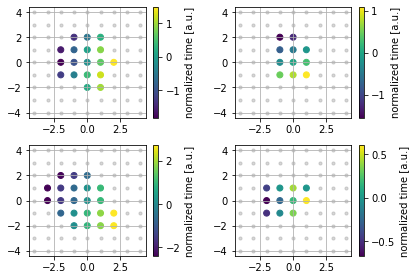

In [6]:
nsamples=len(T)
random_samples = np.random.choice(nsamples, 4)

def rectangular_array(n=9):
    """ Return x,y coordinates for rectangular array with n^2 stations. """
    n0 = (n - 1) / 2
    return (np.mgrid[0:n, 0:n].astype(float) - n0)


for i,j in enumerate(random_samples):
    plt.subplot(2,2,i+1)
    footprint=T[j,...]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 50 * footprint[mask]
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask], 
                          cmap="viridis", alpha=1, label="loud")
    cbar = plt.colorbar(circles)
    cbar.set_label('normalized time [a.u.]')
    plt.grid(True)

plt.tight_layout()
plt.show()

### Input 2: signals

In [7]:
# signal map
S = f['signal']
S = np.log10(1 + S)
S -= np.nanmin(S)
S /= np.nanmax(S)
S[np.isnan(S)] = 0

print(S.shape)

(200000, 9, 9)


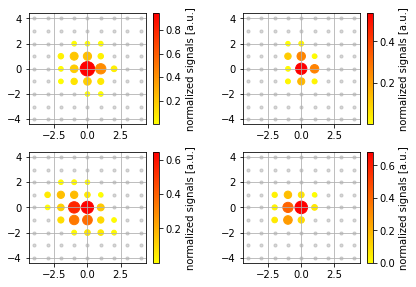

In [8]:
for i,j in enumerate(random_samples):
    plt.subplot(2,2,i+1)
    footprint=S[j,...]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 200 * footprint[mask] + 20
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask], s=marker_size,
                          cmap="autumn_r", alpha=1, label="loud")
    cbar = plt.colorbar(circles)
    cbar.set_label('normalized signals [a.u.]')
    plt.grid(True)

plt.tight_layout()
plt.show()

Combine inputs

In [9]:
X = np.stack([T, S], axis=-1)

### Labels

In [10]:
axis = f['showeraxis']

In [11]:
core = f['showercore'][:, 0:2]
core /= 750

In [12]:
# energy - log10(E/eV) in range [18.5, 20]
logE = f['logE']
logE -= 19.25

In [13]:
X_train, X_test = np.split(X, [-20000])
axis_train, axis_test = np.split(axis, [-20000])
core_train, core_test = np.split(core, [-20000])
logE_train, logE_test = np.split(logE, [-20000])

## Define Model
## Task 
Set up a multi-task regression network for simultaneously predicting shower direction, shower core position, and energy. The network should consist of a common part to the three properties, followed by an individual subnetwork for each property.

In [ ]:
input1 = layers.Input(shape=(9, 9, 2))

# TODO: define a suitable network consisting of 2 parts:
# 1) a common network part (you can try a convolutional stack with ResNet- or
#    DenseNet-like shortcuts)
#   z = ...
# 2) separate network parts for the individual objectives
#   z1 = ...
#   z2 = ...
#   z3 = ...

output1 = layers.Dense(3, name='direction')(z1)
output2 = layers.Dense(2, name='core')(z2)
output3 = layers.Dense(1, name='energy')(z3)

### Task
Train the model to the following precisions:
- Better than $1.5^\circ$ angular resolution
- Better than $25$ m core position resolution
- Better than $10\%$ relative energy uncertainty $\left(\frac{E_\mathrm{pred} - E_\mathrm{true}}{E_\mathrm{true}}\right)$  
  Estimate what these requirements mean in terms of the mean squared error loss and adjust the relative weights in the objective function accordingly.

In [ ]:
loss_weights=[1, 1, 1]  # you can give more weight to individual objectives

model.compile(
    loss=['mse', 'mse', 'mse'],
    loss_weights=loss_weights,
    optimizer=keras.optimizers.Adam(lr=1e-3))

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

fit = model.fit(
    X_train,
    [axis_train, core_train, logE_train],
    batch_size=128,
    epochs=40,
    verbose=2,
    validation_split=0.1,
    callbacks=[ReduceLROnPlateau(factor=0.67, patience=10, verbose=1),
               EarlyStopping(patience=20, verbose=1)])

### Plot training curves

In [ ]:
def plot_history(history, weighted=False):
    fig, ax = plt.subplots(1)
    n = np.arange(len(history['loss']))
    for i, s in enumerate(['axis', 'core', 'energy']):
        w = loss_weights[i] if weighted else 1
        l1 = w * np.array(history['%s_loss' % s])
        l2 = w * np.array(history['val_%s_loss' % s])
        color = 'C%i' % i
        ax.plot(n, l1, c=color, ls='--')
        ax.plot(n, l2, c=color, label=s)

    ax.plot(n, history['loss'], ls='--', c='k')
    ax.plot(n, history['val_loss'], label='sum', c='k')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Weighted Loss' if weighted else 'Loss')
    ax.legend()
    ax.semilogy()
    ax.grid()
    plt.show()

#### Unweighted losses

In [ ]:
plot_history(fit.history, weighted=False)

#### Weighted losses

In [ ]:
plot_history(fit.history, weighted=True)

## Study performance of the DNN

In [ ]:
axis_pred, core_pred, logE_pred = model.predict(X_test, batch_size=128, verbose=1)
logE_pred = logE_pred[:,0]  # remove keras dummy axis

### Reconstruction performance of the shower axis

In [ ]:
d = np.sum(axis_pred * axis_test, axis=1) / np.sum(axis_pred**2, axis=1)**.5
d = np.arccos(np.clip(d, 0, 1)) * 180 / np.pi
reso = np.percentile(d, 68)
plt.figure()
plt.hist(d, bins=np.linspace(0, 3, 41))
plt.axvline(reso, color='C1')
plt.text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.xlabel(r'$\Delta \alpha$ [deg]')
plt.ylabel('#')
plt.grid()
plt.tight_layout()

### Reconstruction performance of the shower core

In [ ]:
d = np.sum((750 * (core_test - core_pred))**2, axis=1)**.5
reso = np.percentile(d, 68)
plt.figure()
plt.hist(d, bins=np.linspace(0, 40, 41))
plt.axvline(reso, color='C1')
plt.text(0.95, 0.95, '$\sigma_{68} = %.2f m$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.xlabel('$\Delta r$ [m]')
plt.ylabel('#')
plt.grid()
plt.tight_layout()

### Reconstruction performance of the shower energy

In [ ]:
d = 10**(logE_pred - logE_test) - 1
reso = np.std(d)
plt.figure()
plt.hist(d, bins=np.linspace(-0.3, 0.3, 41))
plt.xlabel('($E_\mathrm{rec} - E_\mathrm{true}) / E_\mathrm{true}$')
plt.ylabel('#')
plt.text(0.95, 0.95, '$\sigma_\mathrm{rel} = %.3f$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.grid()
plt.tight_layout()

In [ ]:
plt.figure()
plt.scatter(19.25 + logE_test, 19.25 + logE_pred, s=2, alpha=0.3)
plt.plot([18.5, 20], [18.5, 20], color='black')
plt.xlabel('$\log_{10}(E_\mathrm{true}/\mathrm{eV})$')
plt.ylabel('$\log_{10}(E_\mathrm{rec}/\mathrm{eV})$')
plt.grid()
plt.tight_layout()